<a href="https://colab.research.google.com/github/gauthamceee/Landslide-Detection-Using-Satellite-Imagery/blob/main/Landslide_Detection_Using_Satellite_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(r'/content/drive/MyDrive/archive')

Testing the dataset

In [4]:
# Testing the dataset
path_single = r"/content/drive/MyDrive/archive/TestData/img/image_100.h5"
path_single_mask = r'/content/drive/MyDrive/archive/TrainData/mask/mask_100.h5'

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


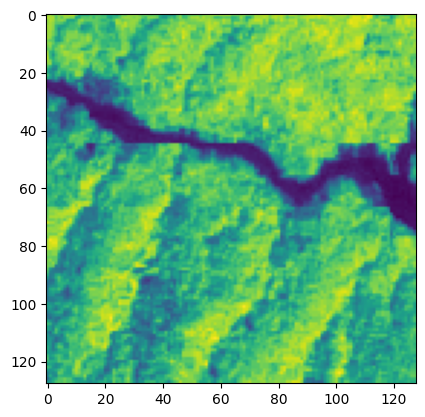

In [5]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])

    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


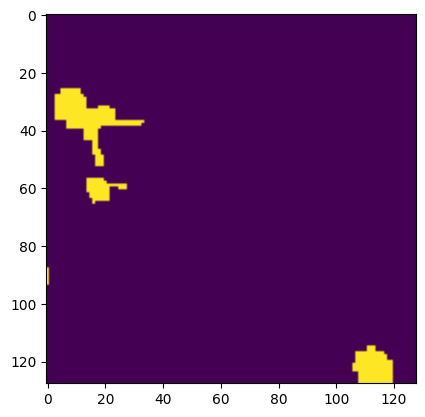

In [6]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

Using all dataset

In [7]:
path_single = r"/content/drive/MyDrive/archive/TrainData/img/image_10.h5"
path_single_mask = r'/content/drive/MyDrive/archive/TrainData/mask/mask_1.h5'
TRAIN_PATH = r"/content/drive/MyDrive/archive/TrainData/img/*.h5"
TRAIN_MASK = r'/content/drive/MyDrive/archive/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

Train with RGB, NDVI, DEM, and Slope

In [8]:
#testing for google colab GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))


        data[np.isnan(data)] = 0.000001


        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0


        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb
        TRAIN_XX[i, :, :, 3] = data_ndvi
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation


    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

0 /content/drive/MyDrive/archive/TrainData/img/image_1.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1.h5
1 /content/drive/MyDrive/archive/TrainData/img/image_10.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_10.h5
2 /content/drive/MyDrive/archive/TrainData/img/image_100.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_100.h5
3 /content/drive/MyDrive/archive/TrainData/img/image_1000.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1000.h5
4 /content/drive/MyDrive/archive/TrainData/img/image_1001.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1001.h5
5 /content/drive/MyDrive/archive/TrainData/img/image_1002.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1002.h5
6 /content/drive/MyDrive/archive/TrainData/img/image_1003.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1003.h5
7 /content/drive/MyDrive/archive/TrainData/img/image_1004.h5 /content/drive/MyDrive/archive/TrainData/mask/mask_1004.h5
8 /content/drive/MyDrive/archive/TrainData/img/image

Testing min, max values in train data

In [ ]:
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

Custom loss function (Dice Loss)

In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

Visualization of the training data

In [ ]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

Validation split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

In [ ]:
img=1545
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [ ]:
x_train.shape, y_train.shape

In [ ]:
# to release some memory, delete the unnecessary variable
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask

In [ ]:
img=1545
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

Unet Model

In [ ]:
from utils import recall_m, precision_m, f1_m
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))
# Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) #Fixed: Corrected indentation
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

In [ ]:
model = unet_model(128, 128, 6)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')

callbacks = [
    # earlyStopping,
    checkpointer
    ]
history = model.fit(x_train, y_train, batch_size=32,
          epochs=100,
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model.save("model_save.h5")

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

Prediction

In [ ]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [ ]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

In [ ]:
img = 255
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

Validation data

In [ ]:
validation_url = r'/content/drive/MyDrive/archive/ValidData/img/image_1.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb
        VAL_XX[i, :, :, 3] = data_ndvi
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation

Prediction for validation data

In [ ]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

Visualization of validation image

In [ ]:
img = 32
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

In [ ]:
write_directory = r'/content/drive/MyDrive/archive/TrainData/mask'
for i, name in enumerate(mask_name):
  h5f = h5py.File(write_directory + "/" + name, 'w')
  # change the dimention of prediction to (n, 128, 128)
  pred_mask = pred_img[i, :, :, 0]

  # write to the directory
  h5f.create_dataset('mask', data = pred_mask)
  h5f.close()